<h3>Data preparation</h3>

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [2]:
# URL of the Friends episode transcript
url = "https://fangj.github.io/friends/season/0101.html" 

# Send an HTTP GET request to fetch the webpage content
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser") 

In [3]:
from collections import defaultdict

# A default dict is used to store interaction counts. The defaylt value is 0 for missing keys
interactions = defaultdict(int)

previous_speaker = None
speaker = None

# Function to split a string with multiple speakers (e.g. "Monica and Rachel")
def split_speaker(speaker):
    return [s.strip() for s in speaker.split(" and ")]

# Iterate over all <p> tags
for p in soup.find_all("p"):
    # Look for a bold tag to identify the speaker
    bold_tag = p.find("b")
    if bold_tag:
        speaker = bold_tag.get_text(strip=True).replace(":", "")
        # Split the speaker string if there's more than one
        speakers = split_speaker(speaker)
    else:
        speakers = []

    if previous_speaker and speakers:
        for s in speakers:
            # Check if the speaker is not a special case
            if previous_speaker not in ["All", "Closing Credits", "Commercial Break", s] and s not in ["All", "Closing Credits", "Commercial Break"]:
                interactions[(previous_speaker, s)] += 1

    previous_speaker = speakers[-1] if speakers else previous_speaker

interactions

defaultdict(int,
            {('Monica', 'Joey'): 9,
             ('Joey', 'Chandler'): 12,
             ('Chandler', 'Phoebe'): 1,
             ('Phoebe', 'Monica'): 7,
             ('Monica', 'Chandler'): 4,
             ('Chandler', 'Joey'): 12,
             ('Joey', 'Phoebe'): 3,
             ('Phoebe', 'Chandler'): 2,
             ('Chandler', 'Monica'): 7,
             ('Chandler', 'Ross'): 6,
             ('Ross', 'Joey'): 9,
             ('Joey', 'Monica'): 9,
             ('Monica', 'Ross'): 14,
             ('Ross', 'Chandler'): 7,
             ('Ross', 'Phoebe'): 4,
             ('Phoebe', 'Ross'): 4,
             ('Ross', 'Monica'): 10,
             ('Joey', 'Ross'): 7,
             ('Monica', 'Rachel'): 20,
             ('Rachel', 'Monica'): 18,
             ('Rachel', 'Ross'): 16,
             ('Ross', 'Rachel'): 13,
             ('Rachel', 'Phoebe'): 4,
             ('Joey', 'Rachel'): 5,
             ('Monica', 'Phoebe'): 5,
             ('Phoebe', 'Rachel'): 2,
       

In [4]:
# New dictonary that contains interaction counts, with speaker pairs treated as unoriented
unoriented_interactions = defaultdict(int)

for (s1, s2), count in interactions.items():
    # Sort the tuple of speakers to ensure the order of speakers does not matter
    key = tuple(sorted([s1, s2]))
    unoriented_interactions[key] += count

unoriented_interactions

defaultdict(int,
            {('Joey', 'Monica'): 18,
             ('Chandler', 'Joey'): 24,
             ('Chandler', 'Phoebe'): 3,
             ('Monica', 'Phoebe'): 12,
             ('Chandler', 'Monica'): 11,
             ('Joey', 'Phoebe'): 4,
             ('Chandler', 'Ross'): 13,
             ('Joey', 'Ross'): 16,
             ('Monica', 'Ross'): 24,
             ('Phoebe', 'Ross'): 8,
             ('Monica', 'Rachel'): 38,
             ('Rachel', 'Ross'): 29,
             ('Phoebe', 'Rachel'): 6,
             ('Joey', 'Rachel'): 6,
             ('Chandler', 'Paul'): 3,
             ('Monica', 'Paul'): 26,
             ('Joey', 'Paul'): 4,
             ('Chandler', 'Rachel'): 13,
             ('Frannie', 'Rachel'): 1,
             ('Frannie', 'Monica'): 8,
             ('Frannie', 'Joey'): 1})

In [5]:
# Store dictionary as csv file
import csv

with open("interactions.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Character1", "Character2", "InteractionCount"]) # Header
    for (char1, char2), count in unoriented_interactions.items():
        writer.writerow([char1, char2, count])

<h3>Create graph</h3>

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

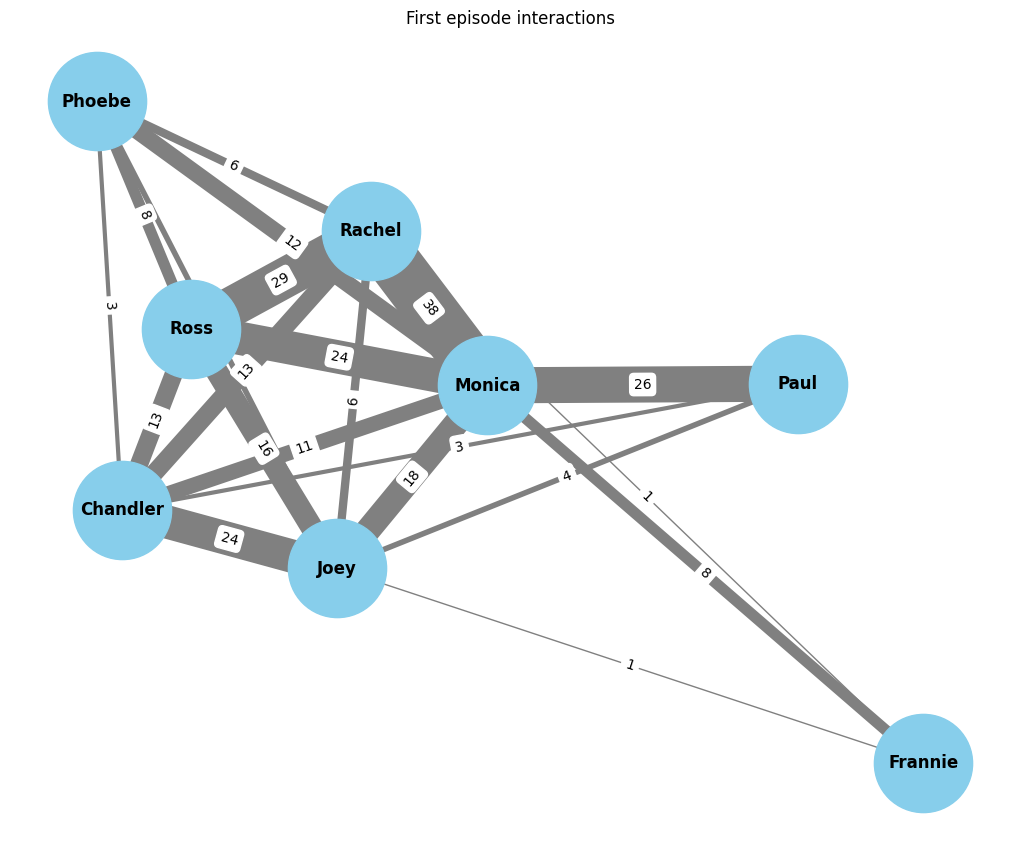

In [7]:
G = nx.Graph()

for (s1, s2), count in unoriented_interactions.items():
    G.add_edge(s1, s2, weight=count)

plt.figure(figsize=(10,8))

edge_weights = [d["weight"] for _, _, d in G.edges(data=True)]

pos = nx.spring_layout(G, weight='weight', seed=42)

nx.draw(G, pos, with_labels=True, node_size=5000, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray", width=edge_weights)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("First episode interactions")
plt.show()

<h3>Metrics</h3>

In [8]:
print(G)

Graph with 8 nodes and 21 edges


In [9]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.75


Density is the ratio of actual edges in the network to all possible edges in the network. It provides a quick sense of how closely knit the network is. 
This graph has a density of 0.75, meaning that 75% of all possible edges are present. Additionally, graph is <b>well-connected</b> - almost everyone interacts with almost everyone else, and there are only a few isolated nodes. This is understandable because there are two characters aside from the six m

<h2>Data from Season 1</h2>

In [10]:
base_url = "https://fangj.github.io/friends/"

response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

episode_links = []
for link in soup.find_all("a"):
    href = link.get("href")
    if href and href.startswith("season/01"):
        episode_links.append(base_url + href)

data = []

for episode_url in episode_links:
    episode_response = requests.get(episode_url)
    episode_soup = BeautifulSoup(episode_response.text, "html.parser")
    data.append([episode_url[-7:-5],episode_soup])

df = pd.DataFrame(data, columns=["Episode", "Dialogue"])

In [11]:
interactions_season_1 = defaultdict(int)

previous_speaker = None
speaker = None

special_cases = ["All", "Closing Credits", "Commercial Break", "Commercial break", "Opening Credits", "The Whole Party", "Both", "", "Girls", "his"]

for episode_dialogue in df["Dialogue"]:
    for p in episode_dialogue.find_all("p"):
        bold_tag = p.find("b")
        if bold_tag:
            speaker = bold_tag.get_text(strip=True).replace(":", "")
            speakers = split_speaker(speaker)
        else:
            speakers = []

        if previous_speaker and speakers:
            for s in speakers:
                if previous_speaker not in special_cases and previous_speaker != s and s not in special_cases:
                    interactions_season_1[(previous_speaker, s)] += 1

        previous_speaker = speakers[-1] if speakers else previous_speaker

In [12]:
len(interactions_season_1)

418

In [13]:
unoriented_interactions_season_1 = defaultdict(int)

for (s1, s2), count in interactions_season_1.items():
    key = tuple(sorted([s1, s2]))
    unoriented_interactions_season_1[key] += count

In [14]:
len(unoriented_interactions_season_1)

264

In [15]:
with open("interactions_season_1.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Character1", "Character2", "InteractionCount"])
    for (char1, char2), count in unoriented_interactions_season_1.items():
        writer.writerow([char1, char2, count])

<h3>Create Graph for Season 1</h3>

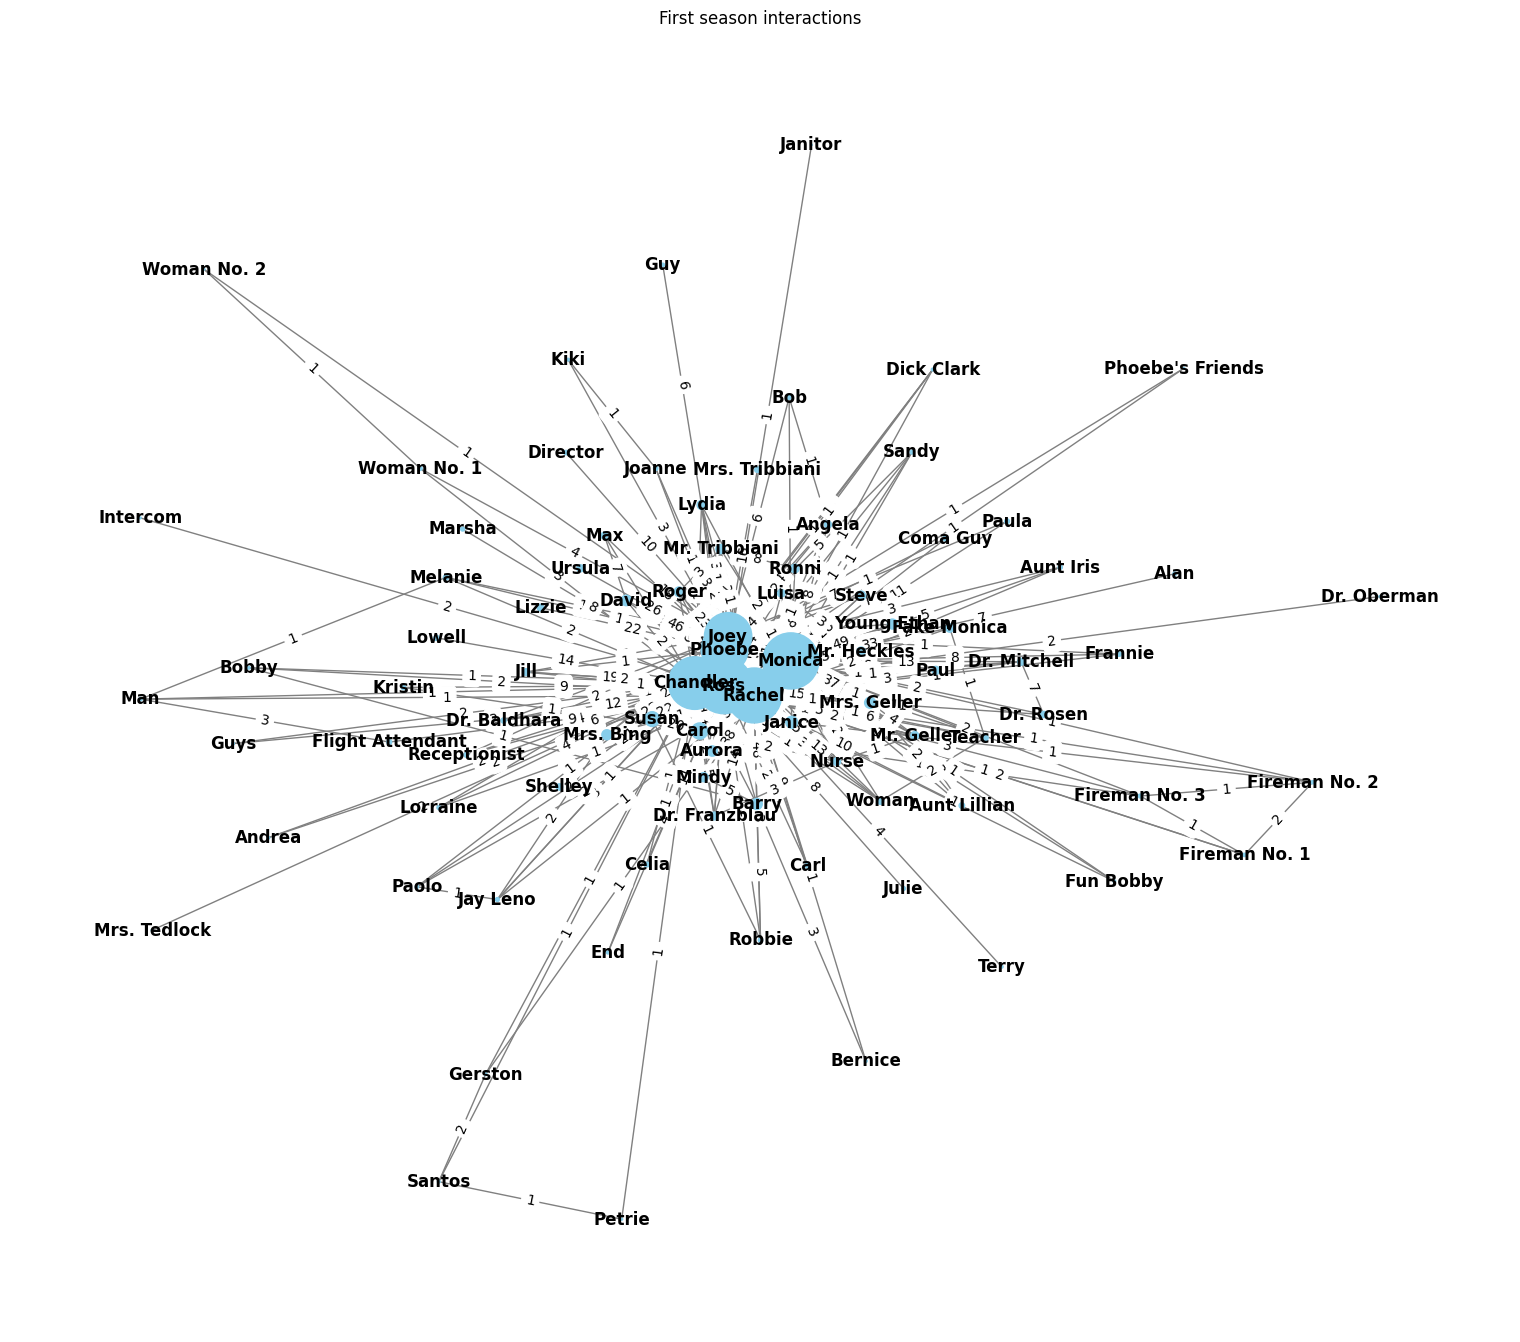

In [16]:
G = nx.Graph()

for (s1, s2), count in unoriented_interactions_season_1.items():
    G.add_edge(s1, s2, weight=count)

plt.figure(figsize=(15,13))

node_sizes = {}
for node in G.nodes():
    total_interactions = sum([G[u][v]['weight'] for u, v in G.edges(node)])
    node_sizes[node] = total_interactions

pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_size=[node_sizes[node] for node in G.nodes()], node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray")

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("First season interactions")
plt.show()

In [17]:
interactions_season_1_df = pd.read_csv("interactions_season_1.csv")
interactions_season_1_df.head()

,Character1,Character2,InteractionCount
0,Joey,Monica,202
1,Chandler,Joey,316
2,Chandler,Phoebe,215
3,Monica,Phoebe,275
4,Chandler,Monica,186


In [18]:
interactions_season_1_df_sorted = interactions_season_1_df.sort_values(by='InteractionCount', ascending=False)
interactions_season_1_df_sorted.head(20)

,Character1,Character2,InteractionCount
10,Monica,Rachel,437
11,Rachel,Ross,395
1,Chandler,Joey,316
7,Joey,Ross,286
6,Chandler,Ross,278
3,Monica,Phoebe,275
8,Monica,Ross,221
2,Chandler,Phoebe,215
12,Phoebe,Rachel,208
0,Joey,Monica,202


In [19]:
new_df = interactions_season_1_df_sorted[interactions_season_1_df_sorted['InteractionCount'] >= 60]
new_df

,Character1,Character2,InteractionCount
10,Monica,Rachel,437
11,Rachel,Ross,395
1,Chandler,Joey,316
7,Joey,Ross,286
6,Chandler,Ross,278
3,Monica,Phoebe,275
8,Monica,Ross,221
2,Chandler,Phoebe,215
12,Phoebe,Rachel,208
0,Joey,Monica,202


In [38]:
len(new_df)

18

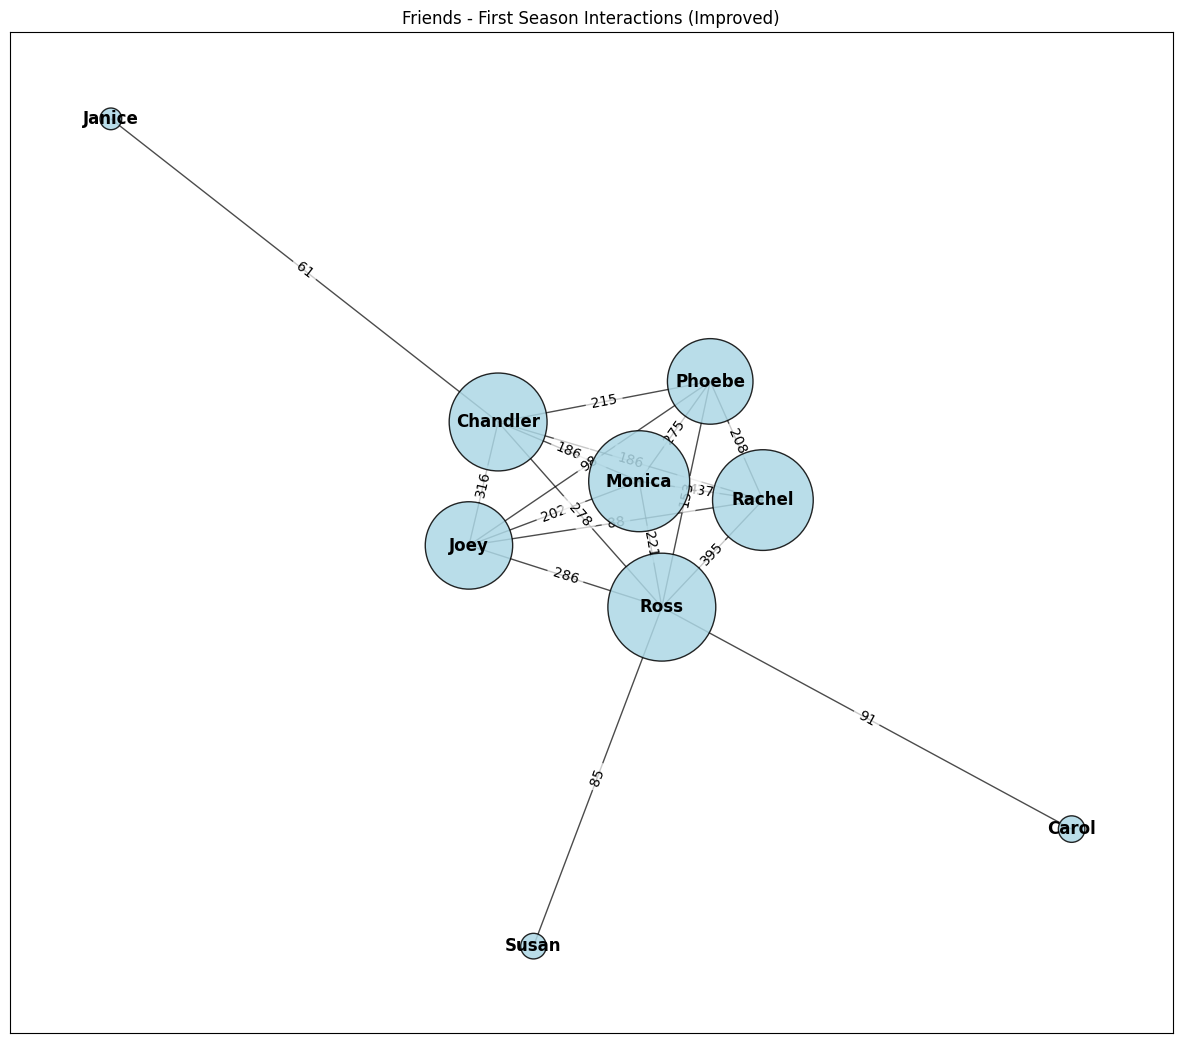

In [22]:
import matplotlib.cm as cm

G1 = nx.Graph()

for _, row in new_df.iterrows():
    s1, s2, count = row['Character1'], row['Character2'], row['InteractionCount']
    G1.add_edge(s1, s2, weight=count)

plt.figure(figsize=(15,13))

node_sizes = np.array([sum(G1[u][v]['weight'] * 4 for u, v in G1.edges(node)) for node in G.nodes()])

pos = nx.spring_layout(G1, seed=42)

nx.draw_networkx_nodes(G1, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black", alpha=0.85)
nx.draw_networkx_edges(G1, pos, alpha=0.7)
nx.draw_networkx_labels(G1, pos, font_size=12, font_weight="bold")

edge_labels = nx.get_edge_attributes(G1, 'weight')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels, font_size=10,
                             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title("Friends - First Season Interactions (Improved)")
plt.show()

<h2>Season 4</h2>

In [23]:
episode_links_s4 = []
for link in soup.find_all("a"):
    href = link.get("href")
    if href and href.startswith("season/04"):
        episode_links_s4.append(base_url + href)

data_s4 = []

for episode_url in episode_links_s4:
    episode_response = requests.get(episode_url)
    episode_soup = BeautifulSoup(episode_response.text, "html.parser")
    data_s4.append([episode_url[-7:-5],episode_soup])

df_s4 = pd.DataFrame(data_s4, columns=["Episode", "Dialogue"])
df_s4

,Episode,Dialogue
0,01,"[[\n, [\n, <title>The One With The Jellyfish</..."
1,02,"[[\n, [\n, <title>The One With The Cat</title>..."
2,03,"[[\n, [\n, <meta content=""text/html; charset=u..."
3,04,"[[\n, [\n, <title>The One With The Ballroom Da..."
4,05,"[[\n, [\n, <title>The One With Joey's New Girl..."
5,06,"[[\n, [\n, <meta content=""text/html; charset=u..."
6,07,"[[\n, [\n, <title>The One Where Chandler Cross..."
7,08,"[[\n, [\n, <title>The One With Chandler In A B..."
8,09,"[[\n, [\n, <title>The One Where They're Gonna ..."
9,10,"[[\n, [\n, <title>The One With The Girl From P..."


In [24]:
def split_speaker(speaker):
    parts = [s.strip() for s in speaker.split(" and ")]
    split_parts = []
    for part in parts:
        split_parts.extend([s.strip() for s in part.split(",")])
    return split_parts

def split_speaker2(speaker):
    return [s.strip() for s in speaker.split(",")]

In [25]:
interactions_season_4 = defaultdict(int)

previous_speaker = None
speaker = None

special_cases = ["Opening Credits", "Commercial Break", "Closing Credits", "Opening Credits", "All", "Commercial break", "", "throwing", "wearing", "End"]

for episode_dialogue in df_s4["Dialogue"]:
    for p in episode_dialogue.find_all("p"):
        bold_tag = p.find("b")
        if bold_tag:
            speaker = bold_tag.get_text(strip=True).replace(":", "")
            if 'and' in speaker:
                speakers = split_speaker(speaker)
            else:
                speakers = split_speaker2(speaker)
        else:
            speakers = []

        if previous_speaker and speakers:
            for s in speakers:
                if previous_speaker not in special_cases and previous_speaker != s and s not in special_cases:
                    interactions_season_4[(previous_speaker, s)] += 1

        previous_speaker = speakers[-1] if speakers else previous_speaker

In [26]:
len(interactions_season_4)

336

In [27]:
unoriented_interactions_season_4 = defaultdict(int)

for (s1, s2), count in interactions_season_4.items():
    key = tuple(sorted([s1, s2]))
    unoriented_interactions_season_4[key] += count

In [28]:
len(unoriented_interactions_season_4)

209

In [29]:
with open("interactions_season_4.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Character1", "Character2", "InteractionCount"])
    for (char1, char2), count in unoriented_interactions_season_4.items():
        writer.writerow([char1, char2, count])

In [30]:
df_s4 = pd.read_csv("interactions_season_4.csv")
df_s4.sort_values(by='InteractionCount', ascending=False).head(40)

,Character1,Character2,InteractionCount
3,Chandler,Joey,526
5,Rachel,Ross,381
15,Monica,Rachel,319
8,Monica,Phoebe,264
16,Phoebe,Rachel,245
4,Joey,Ross,225
17,Chandler,Ross,223
11,Monica,Ross,206
13,Joey,Monica,185
12,Chandler,Rachel,182


In [31]:
new_df_s4 = df_s4[df_s4['InteractionCount'] >= 100]
new_df_s4

,Character1,Character2,InteractionCount
2,Joey,Phoebe,161
3,Chandler,Joey,526
4,Joey,Ross,225
5,Rachel,Ross,381
8,Monica,Phoebe,264
9,Chandler,Monica,182
10,Chandler,Phoebe,177
11,Monica,Ross,206
12,Chandler,Rachel,182
13,Joey,Monica,185


In [37]:
len(new_df_s4)

18

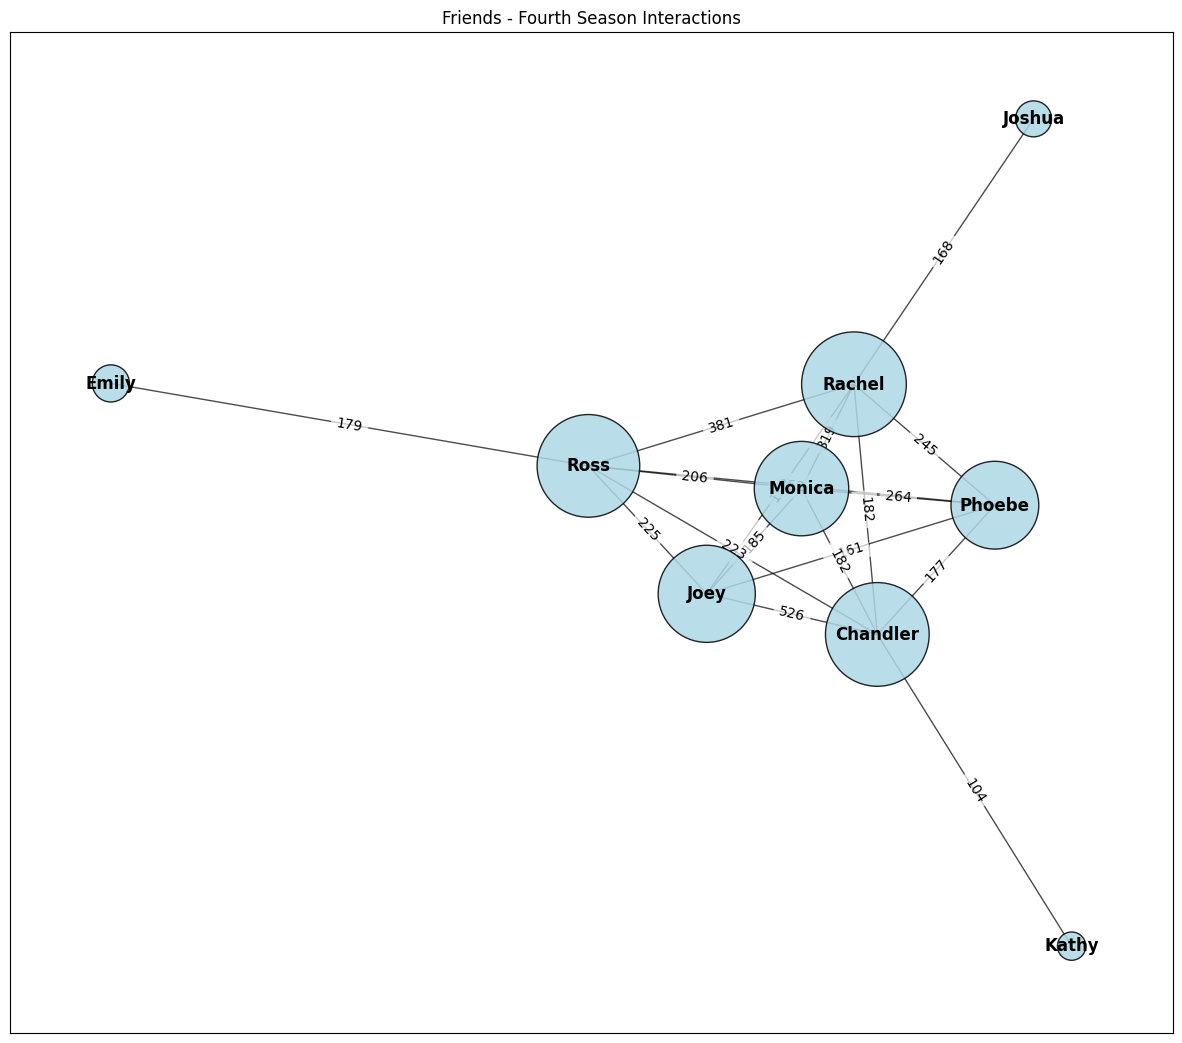

In [32]:
G4 = nx.Graph()

for _, row in new_df_s4.iterrows():
    s1, s2, count = row['Character1'], row['Character2'], row['InteractionCount']
    G4.add_edge(s1, s2, weight=count)

plt.figure(figsize=(15,13))

node_sizes = np.array([sum(G4[u][v]['weight'] * 4 for u, v in G4.edges(node)) for node in G4.nodes()])

pos = nx.spring_layout(G4, seed=42)

nx.draw_networkx_nodes(G4, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black", alpha=0.85)
nx.draw_networkx_edges(G4, pos, alpha=0.7)
nx.draw_networkx_labels(G4, pos, font_size=12, font_weight="bold")

edge_labels = nx.get_edge_attributes(G4, 'weight')
nx.draw_networkx_edge_labels(G4, pos, edge_labels=edge_labels, font_size=10,
                             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title("Friends - Fourth Season Interactions")
plt.show()

In [36]:
print(G1, G4)

Graph with 9 nodes and 18 edges Graph with 9 nodes and 18 edges


In [47]:
avg_degree_s1 = sum(dict(G1.degree()).values()) / G1.number_of_nodes()
avg_degree_s4 = sum(dict(G4.degree()).values()) / G4.number_of_nodes()
print(f'Average degree - S1: {avg_degree_s1}, S4: {avg_degree_s4}')

Average degree - S1: 4.0, S4: 4.0


In [48]:
avg_shortest_path_s1 = nx.average_shortest_path_length(G1)
avg_shortest_path_s4 = nx.average_shortest_path_length(G4)
print(f"Agerage Shortest Path - S1: {avg_shortest_path_s1}, S4: {avg_shortest_path_s4}")

Agerage Shortest Path - S1: 1.5555555555555556, S4: 1.5833333333333333


In [49]:
diameter_s1 = nx.diameter(G1)
diameter_s4 = nx.diameter(G4)
print(f"Graph Diameter - S1: {diameter_s1}, S4: {diameter_s4}")

Graph Diameter - S1: 3, S4: 3


In [50]:
clustering_coefficient_s1 = nx.average_clustering(G1)
clustering_coefficient_s4 = nx.average_clustering(G4)
print(f"Clustering Coefficient - S1: {clustering_coefficient_s1}, S4: {clustering_coefficient_s4}")

Clustering Coefficient - S1: 0.5714285714285714, S4: 0.5555555555555556


In [51]:
degree_centrality_s1 = nx.degree_centrality(G1)
degree_centrality_s4 = nx.degree_centrality(G4)

Degree Centrality - S1: {'Monica': 0.625, 'Rachel': 0.625, 'Ross': 0.875, 'Chandler': 0.75, 'Joey': 0.625, 'Phoebe': 0.625, 'Carol': 0.125, 'Susan': 0.125, 'Janice': 0.125}, S4: {'Joey': 0.625, 'Phoebe': 0.625, 'Chandler': 0.75, 'Ross': 0.75, 'Rachel': 0.75, 'Monica': 0.625, 'Kathy': 0.125, 'Joshua': 0.125, 'Emily': 0.125}


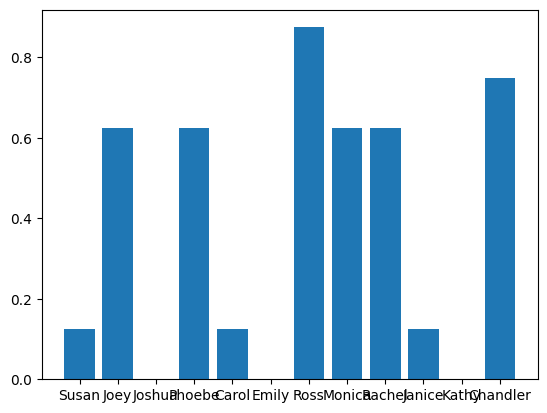

In [88]:
plt.bar(degree_centrality_s1.keys(), degree_centrality_s1.values())
plt.show()

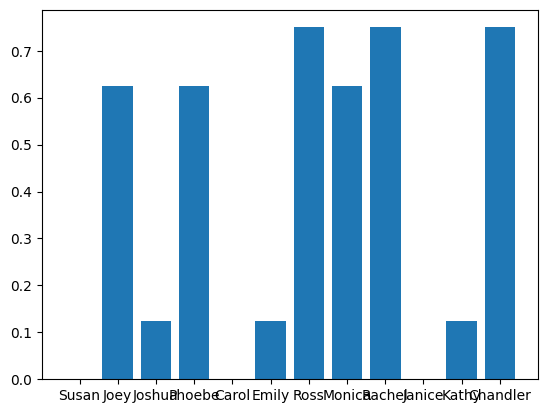

In [89]:
plt.bar(degree_centrality_s4.keys(), degree_centrality_s4.values())
plt.show()

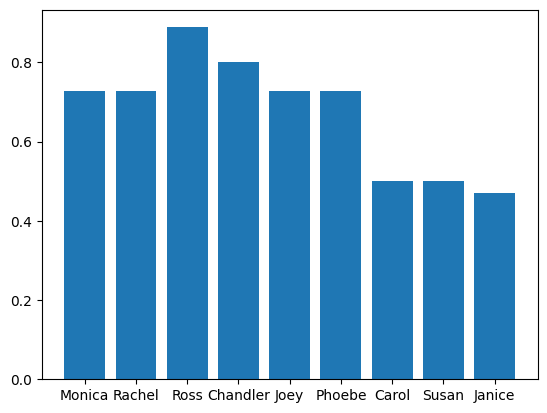

In [90]:
closeness_centrality_s1 = nx.closeness_centrality(G1)
plt.bar(closeness_centrality_s1.keys(), closeness_centrality_s1.values())
plt.show()

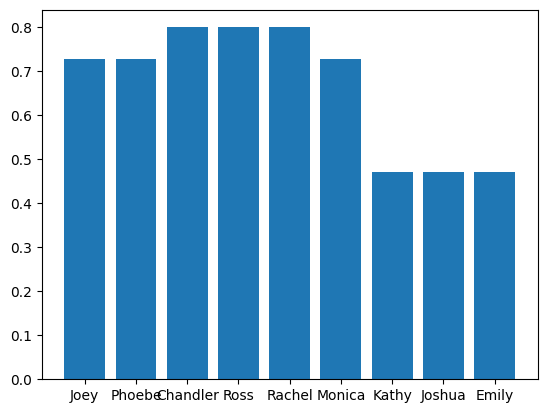

In [91]:
closeness_centrality_s4 = nx.closeness_centrality(G4)
plt.bar(closeness_centrality_s4.keys(), closeness_centrality_s4.values())
plt.show()

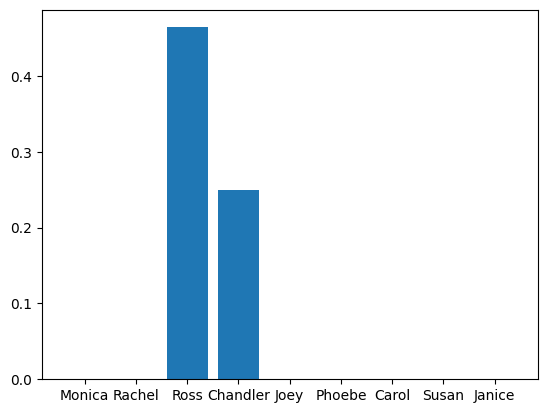

In [95]:
betweenness_centrality_s1 = nx.betweenness_centrality(G1)
betweenness_centrality_s4 = nx.betweenness_centrality(G4)
plt.bar(betweenness_centrality_s1.keys(), betweenness_centrality_s1.values())
plt.show()

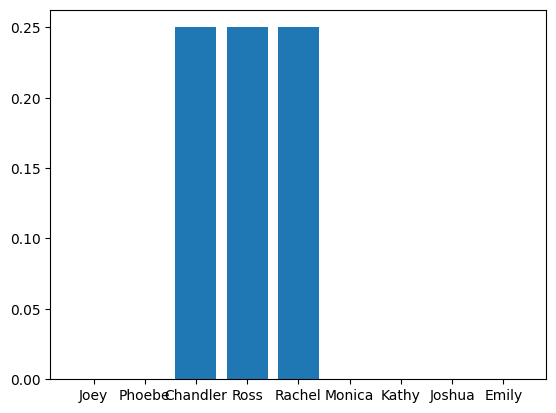

In [96]:
plt.bar(betweenness_centrality_s4.keys(), betweenness_centrality_s4.values())
plt.show()